In [1]:
import re
import json
import keras
import string
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hazm import word_tokenize
from keras.models import Model
from keras.datasets import imdb
from sklearn.utils import shuffle
from gensim.models.word2vec import Word2Vec
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from keras.layers import LSTM, Activation, Dropout, Dense, Input

# Reading Json File

In [2]:
# Opening JSON file
with open('train_final', encoding='utf-8') as json_file:
    df_data = []
    df_labels = []
    data = json.load(json_file)
    for i in range(len(data)):
        category_data = data[i]['input_list'][0]['post_list']
        category_labels = [data[i]['category']] * len(category_data)
        df_data += category_data
        df_labels += category_labels

    df = pd.DataFrame(
    {'Sentence': df_data,
     'Label': df_labels
    })

# Data Sample

In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Sentence,Label
0,@irancell از طریق گوشی4جی و با استفاده از بسته...,negative
1,یه منشی خانم با حقوق ملیونی نیازمندیم... متاهل...,neutral
2,۱۹ تیر ۲/۵ گیگ با ۵ گیگ شبانه زورکی دادین امرو...,negative
3,بهاره کیان افشار,neutral
4,حرومزاده,negative
...,...,...
9331,شمایید بزرگترین اپراتور دیتای ایران😐😂,negative
9332,سلام میگم یک گیگ 100تومان واقعیت داره,neutral
9333,@irancell سلام ایرانسل عزیز آیا طرح یک ساعت مک...,neutral
9334,ایرانسل ۱۴ گیگ اینترنت هدیه دیروز به من دادی ...,negative


# Removing Mentions

In [4]:
# replace the matching strings
df = df.replace(to_replace ='(@[A-Za-z0-9]+)', value = '', regex = True)
df

,Sentence,Label
0,از طریق گوشی4جی و با استفاده از بسته های نامح...,negative
1,یه منشی خانم با حقوق ملیونی نیازمندیم... متاهل...,neutral
2,۱۹ تیر ۲/۵ گیگ با ۵ گیگ شبانه زورکی دادین امرو...,negative
3,بهاره کیان افشار,neutral
4,حرومزاده,negative
...,...,...
9331,شمایید بزرگترین اپراتور دیتای ایران😐😂,negative
9332,سلام میگم یک گیگ 100تومان واقعیت داره,neutral
9333,سلام ایرانسل عزیز آیا طرح یک ساعت مکالمه رایگ...,neutral
9334,ایرانسل ۱۴ گیگ اینترنت هدیه دیروز به من دادی ...,negative


# Removing stopwords from persian nonverbal stopwords file alongside

In [5]:
def remove_stopwords(data, stopwords_file):
    with open(stopwords_file,encoding="utf-8") as f:
        stopwords = [list(map(str, line.split())) for line in f]
        stopwords = [word[0] for word in stopwords]
        print(stopwords)
        data['review without stopwords'] = data['Sentence'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

In [6]:
df = remove_stopwords(df, 'nonverbal')
# data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
df['clean_review'] = df['review without stopwords'].str.replace('[{}]'.format(string.punctuation), ' ')
df

['دیگران', 'همچنان', 'مدت', 'چیز', 'سایر', 'جا', 'طی', 'کل', 'کنونی', 'بیرون', 'مثلا', 'کامل', 'کاملا', 'آنکه', 'موارد', 'واقعی', 'امور', 'امورات', 'اکنون', 'بطور', 'به', 'بخشی', 'تحت', 'چگونه', 'عدم', 'نوعی', 'حاضر', 'وضع', 'مقابل', 'کنار', 'خویش', 'نگاه', 'درون', 'زمانی', 'بنابراین', 'بنابرین', 'تو', 'خیلی', 'بزرگ', 'خودش', 'جز', 'اینجا', 'مختلف', 'توسط', 'نوع', 'همچنین', 'آنجا', 'قبل', 'جناح', 'اینها', 'طور', 'شاید', 'ایشان', 'جهت', 'طریق', 'مانند', 'پیدا', 'ممکن', 'کسانی', 'جای', 'کسی', 'غیر', 'بی', 'قابل', 'درباره', 'جدید', 'وقتی', 'اخیر', 'چرا', 'بیش', 'روی', 'طرف', 'جریان', 'زیر', 'آنچه', 'البته', 'فقط', 'چیزی', 'چون', 'برابر', 'هنوز', 'بخش', 'زمینه', 'بین', 'بدون', 'استفاد', 'همان', 'نشان', 'بسیاری', 'بعد', 'عمل', 'روز', 'اعلام', 'چند', 'آنان', 'بلکه', 'امروز', 'تمام', 'بیشتر', 'آیا', 'برخی', 'علیه', 'دیگری', 'ویژه', 'گذشته', 'انجام', 'حتی', 'داده', 'راه', 'سوی', 'ولی', 'زمان', 'حال', 'تنها', 'بسیار', 'یعنی', 'عنوان', 'همین', 'هبچ', 'پیش', 'وی', 'یکی', 'اینکه', 'وجود', 'شما', '

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence,Label,review without stopwords,clean_review
0,از طریق گوشی4جی و با استفاده از بسته های نامح...,negative,گوشی4جی استفاده بسته های نامحدود ساعتی قبلا سر...,گوشی4جی استفاده بسته های نامحدود ساعتی قبلا سر...
1,یه منشی خانم با حقوق ملیونی نیازمندیم... متاهل...,neutral,یه منشی خانم حقوق ملیونی نیازمندیم... متاهل مجرد,یه منشی خانم حقوق ملیونی نیازمندیم متاهل مجرد
2,۱۹ تیر ۲/۵ گیگ با ۵ گیگ شبانه زورکی دادین امرو...,negative,۱۹ تیر ۲/۵ گیگ ۵ گیگ شبانه زورکی دادین ۲۱ تیره...,۱۹ تیر ۲ ۵ گیگ ۵ گیگ شبانه زورکی دادین ۲۱ تیره...
3,بهاره کیان افشار,neutral,بهاره کیان افشار,بهاره کیان افشار
4,حرومزاده,negative,حرومزاده,حرومزاده
...,...,...,...,...
9331,شمایید بزرگترین اپراتور دیتای ایران😐😂,negative,شمایید بزرگترین اپراتور دیتای ایران😐😂,شمایید بزرگترین اپراتور دیتای ایران😐😂
9332,سلام میگم یک گیگ 100تومان واقعیت داره,neutral,سلام میگم گیگ 100تومان واقعیت داره,سلام میگم گیگ 100تومان واقعیت داره
9333,سلام ایرانسل عزیز آیا طرح یک ساعت مکالمه رایگ...,neutral,سلام ایرانسل عزیز طرح ساعت مکالمه رایگان دائمی...,سلام ایرانسل عزیز طرح ساعت مکالمه رایگان دائمی...
9334,ایرانسل ۱۴ گیگ اینترنت هدیه دیروز به من دادی ...,negative,ایرانسل ۱۴ گیگ اینترنت هدیه دیروز دادی پیام دا...,ایرانسل ۱۴ گیگ اینترنت هدیه دیروز دادی پیام دا...


In [7]:
y = pd.get_dummies(df['Label']).values
sentences = df['clean_review']
X_train = sentences
Y_train = y

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [9]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Glove Vector Function

In [10]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

# Creating the embedding layer

In [11]:
word_to_vec_map = read_glove_vector('vectors.txt')

maxLen = 20

vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['سلام'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len,
                            output_dim=embed_vector_len,
                            input_length=maxLen,
                            weights = [emb_matrix],
                            trainable=False)

# Model structure function

In [12]:
def persian_tc(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.5)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.5)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.5)(X)

  X = LSTM(64)(X)
  
  X = Dense(3, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [13]:
model = persian_tc((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 50)            1083650   
                                                                 
 lstm (LSTM)                 (None, 20, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           131584

# Tokenizing and padding the training data

In [14]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(9336, 20)

In [15]:
adam = keras.optimizers.adam_v2.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
X_train_indices, Y_train = shuffle(X_train_indices, Y_train)

In [18]:
checkpoint_filepath = 'W_glove'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
history = model.fit(X_train_indices,
                    Y_train,
                    validation_split=0.2,
                    callbacks=[model_checkpoint_callback],
                    batch_size=32,
                    epochs=50)

Epoch 1/50
234/234 [==============================] - 15s 44ms/step - loss: 0.9105 - accuracy: 0.5708 - val_loss: 0.8642 - val_accuracy: 0.6151
Epoch 2/50
234/234 [==============================] - 11s 47ms/step - loss: 0.8209 - accuracy: 0.6324 - val_loss: 0.8194 - val_accuracy: 0.6440
Epoch 3/50
234/234 [==============================] - 11s 47ms/step - loss: 0.7619 - accuracy: 0.6666 - val_loss: 0.7548 - val_accuracy: 0.6676
Epoch 4/50
234/234 [==============================] - 11s 48ms/step - loss: 0.7142 - accuracy: 0.6892 - val_loss: 0.7511 - val_accuracy: 0.6692
Epoch 5/50
234/234 [==============================] - 11s 47ms/step - loss: 0.6701 - accuracy: 0.7163 - val_loss: 0.7239 - val_accuracy: 0.6884
Epoch 6/50
234/234 [==============================] - 11s 47ms/step - loss: 0.6364 - accuracy: 0.7310 - val_loss: 0.6880 - val_accuracy: 0.7104
Epoch 7/50
234/234 [==============================] - 11s 46ms/step - loss: 0.6098 - accuracy: 0.7484 - val_loss: 0.7556 - val_accuracy:

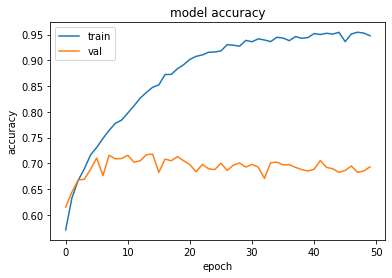

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

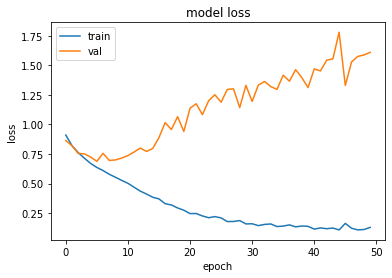

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Loading the model with best validation accuracy

In [23]:
checkpoint_filepath = "W_glove/W_glove"
model.load_weights(checkpoint_filepath)

In [24]:
with open('validation_final', encoding='utf-8') as json_file:
    df_data = []
    df_labels = []
    data = json.load(json_file)
    for i in range(len(data)):
        category_data = data[i]['input_list'][0]['post_list']
        category_labels = [data[i]['category']] * len(category_data)
        df_data += category_data
        df_labels += category_labels

    df_val = pd.DataFrame(
    {'Sentence': df_data,
     'Label': df_labels
    })

In [25]:
df_val = df_val.replace(to_replace ='(@[A-Za-z0-9]+)', value = '', regex = True)

df_val = remove_stopwords(df_val, 'nonverbal')
df_val['clean_review'] = df_val['review without stopwords'].str.replace('[{}]'.format(string.punctuation), ' ')

y_val = pd.get_dummies(df_val['Label']).values
sentences = df_val['clean_review']

X_val = sentences
Y_val = y_val

X_val_indices = tokenizer.texts_to_sequences(X_val)

X_val_indices = pad_sequences(X_val_indices, maxlen=maxLen, padding='post')
X_val_indices.shape

['دیگران', 'همچنان', 'مدت', 'چیز', 'سایر', 'جا', 'طی', 'کل', 'کنونی', 'بیرون', 'مثلا', 'کامل', 'کاملا', 'آنکه', 'موارد', 'واقعی', 'امور', 'امورات', 'اکنون', 'بطور', 'به', 'بخشی', 'تحت', 'چگونه', 'عدم', 'نوعی', 'حاضر', 'وضع', 'مقابل', 'کنار', 'خویش', 'نگاه', 'درون', 'زمانی', 'بنابراین', 'بنابرین', 'تو', 'خیلی', 'بزرگ', 'خودش', 'جز', 'اینجا', 'مختلف', 'توسط', 'نوع', 'همچنین', 'آنجا', 'قبل', 'جناح', 'اینها', 'طور', 'شاید', 'ایشان', 'جهت', 'طریق', 'مانند', 'پیدا', 'ممکن', 'کسانی', 'جای', 'کسی', 'غیر', 'بی', 'قابل', 'درباره', 'جدید', 'وقتی', 'اخیر', 'چرا', 'بیش', 'روی', 'طرف', 'جریان', 'زیر', 'آنچه', 'البته', 'فقط', 'چیزی', 'چون', 'برابر', 'هنوز', 'بخش', 'زمینه', 'بین', 'بدون', 'استفاد', 'همان', 'نشان', 'بسیاری', 'بعد', 'عمل', 'روز', 'اعلام', 'چند', 'آنان', 'بلکه', 'امروز', 'تمام', 'بیشتر', 'آیا', 'برخی', 'علیه', 'دیگری', 'ویژه', 'گذشته', 'انجام', 'حتی', 'داده', 'راه', 'سوی', 'ولی', 'زمان', 'حال', 'تنها', 'بسیار', 'یعنی', 'عنوان', 'همین', 'هبچ', 'پیش', 'وی', 'یکی', 'اینکه', 'وجود', 'شما', '

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


(450, 20)

# Loss and Accuracy on unseen data

In [26]:
model.evaluate(X_val_indices, Y_val)

15/15 [==============================] - 0s 14ms/step - loss: 0.9137 - accuracy: 0.6267


[0.9137117266654968, 0.6266666650772095]